In [1]:
import tensorflow as tf 
from tensorflow_probability.python import distributions as tfd  
from tensorflow_probability import layers as tfl 
import numpy as np 

2024-05-04 04:15:52.370706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 04:15:52.384465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 04:15:54.062910: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 04:15:57.845611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 04:16:15.887931: W tensorflow/compiler/tf2

In [2]:
tf.config.experimental.set_memory_growth(tf.config.get_visible_devices("GPU")[0], True)

2024-05-04 04:17:22.007147: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 04:17:22.821884: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 04:17:22.821970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
from src import models, layers, utils
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

reload(utils)
reload(layers)
reload(models)

length = 100
samples = 150
sin = True 
if sin:
    out_dim = 1
    clusters = 3
    traj = utils.generate_sin((0.1, 0.9, 2.0), noise=0.1, length=length, samples=samples)
    traj = tf.cast(
    tf.expand_dims(tf.transpose(tf.reshape(traj, (length, -1)), (1, 0)), -1),
    tf.float32,
    )
else:
    out_dim = 2
    clusters = 2
    traj = utils.generate_trajectories(length=length, samples=samples) 
    traj = tf.reshape(traj, (length, -1, 2))
    traj = tf.transpose(traj, (1, 0, 2))

2024-05-04 04:17:46.402513: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 04:17:46.402700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 04:17:46.402747: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 04:17:46.982145: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 04:17:46.982456: I external/local_xla/xla/stream_executor

In [ ]:
class Custom(tf.keras.models.Model):
    def __init__(self, units, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.dense = tf.keras.layers.Dense(units*2, activation)
        self.dl = tfl.DistributionLambda(make_distribution_fn= lambda t: tfd.MultivariateNormalDiag(t[..., :self.units], tf.exp(t[..., self.units:])),
                                         convert_to_tensor_fn=lambda s: tf.squeeze(s.sample(1), 0))
    @tf.function 
    def call(self, inputs, *args):
        params = self.dense(inputs)
        return self.dl(params)

x = tf.cast(tf.random.normal(shape=(100, 1)), tf.float32)
custom = Custom(2)
output = custom(x)

custom.save("./model_normal_test")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(custom)
converted = converter.convert()
with open("./tflitemodel2.tflite", "wb") as file:
    file.write(converted)

In [ ]:
def make_lambda(t):
    return tfd.OneHotCategorical(logits=tf.ones_like(t, dtype=tf.float32))

class Custom2(tf.keras.models.Model):
    def __init__(self, units, activation="relu", clusters=5, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.dl = tfl.DistributionLambda(make_distribution_fn= make_lambda, #lambda t: tfd.OneHotCategorical(logits=tf.ones_like(t, dtype=tf.float32)), 
                                         convert_to_tensor_fn=lambda s: tf.squeeze(s.sample(1), 0))
        self.dl2 = tfd.OneHotCategorical(logits=tf.ones(clusters, dtype=tf.float32))
        self.clusters = clusters 

    def build(self, input_shape):
        super().build(input_shape)

    @tf.function 
    def call(self, inputs, *args):
        B, d = tf.shape(inputs)[0], tf.shape(inputs)[1]
        x = tf.ones((B, d))
        print(B, d)
        print(x.shape)
        return self.dl(x), self.dl2.sample((B))

x = tf.cast(tf.random.normal(shape=(100, 5)), tf.float32)
custom = Custom2(2)
output = custom(x)

print("Saving...")
custom.compile("adam")
custom.save("./custom_model_test")

In [ ]:
from src import models, layers, utils
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np

reload(utils)
reload(models)
reload(layers)

length = 100
samples = 150
epochs = 1000

traj = utils.generate_trajectories(length=length, samples=samples) 
traj = tf.reshape(traj, (length, -1, 2))
traj = tf.transpose(traj, (1, 0, 2))

kl_zd_schedule = utils.KlScheduler("zd_loss_weight", 10)
kl_zg_schedule = utils.KlScheduler("zg_loss_weight", 10)
kl_p_schedule = utils.KlScheduler("entr_weight", 10)
vmrnn1 = models.VariationalMixtureRNN(output_units=2, hidden_units=10, clusters=2, use_sample_kl=True)
vmrnn1.compile("rmsprop")
_ = vmrnn1(traj)
'''hist = vmrnn1.fit(
    traj,
    epochs=epochs,
    batch_size=samples,
    callbacks=[kl_zd_schedule, kl_zg_schedule, kl_p_schedule],
)
vmrnn1.save("vmrnn1.keras")'''

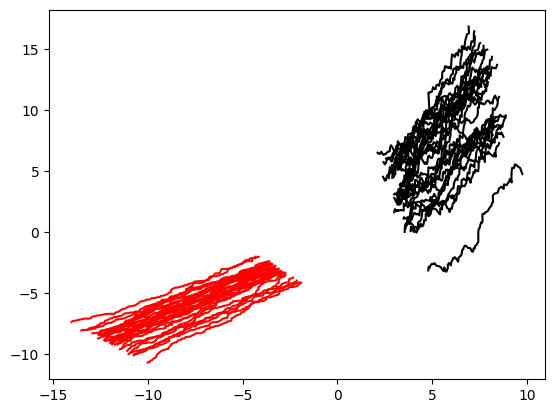

In [27]:
for i in range(30):
    plt.plot(traj[:, i, 0, 0], traj[:, i, 0, 1], color="black")
    plt.plot(traj[:, i, 1, 0], traj[:, i, 1, 1], color="red")

In [37]:
from src import data
from importlib import reload 

reload(data)
#path = "A:\\Users\\Claudio\\Documents\\Data\\motion-sense\\data"
path = "/mnt/a/Users/Claudio/Documents/PROJECTS/Variational-Latent-Sequence-Clustering/assets/data/motion_sense.csv"
subjects = data.load_motion_sense(path)

In [38]:
comverted = data.df_to_matrix(subjects)

DataFrame to Matrix conversion
Processing indices...


100%|██████████| 16424/16424 [00:00<00:00, 564307.30it/s]


Assigning values to indices...


100%|██████████| 1412865/1412865 [02:11<00:00, 10707.94it/s]


In [43]:
dataset = comverted[0]

In [79]:
subjects.columns

Index(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x',
       'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.y',
       'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y',
       'userAcceleration.z'],
      dtype='object')

In [48]:
dataset.shape

(24, 15, 16424, 12)

In [29]:
reload(models)
rnnmodel = models.RecurrentNN(1, 15, activation="tanh", recurrent_activation="tanh")
o = rnnmodel(traj)
o = rnnmodel.sample(traj)

In [34]:
reload(models)
rnnmodel2 = models.RecurrentNN(1, 15, activation="tanh", recurrent_activation="tanh")
_ = rnnmodel2(traj)
rnnmodel2.set_weights(rnnmodel.get_weights())
rnnmodel = rnnmodel2

In [30]:
rnnmodel.compile("rmsprop")
rnnmodel.fit(traj, epochs=500, batch_size=450)

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 0.4319
Epoch 2/500
1/1 [==============================] - 0s 261ms/step - loss: 0.4276
Epoch 3/500
1/1 [==============================] - 0s 248ms/step - loss: 0.4249
Epoch 4/500
1/1 [==============================] - 0s 245ms/step - loss: 0.4229
Epoch 5/500
1/1 [==============================] - 0s 272ms/step - loss: 0.4212
Epoch 6/500
1/1 [==============================] - 0s 384ms/step - loss: 0.4197
Epoch 7/500
1/1 [==============================] - 0s 239ms/step - loss: 0.4184
Epoch 8/500
1/1 [==============================] - 0s 211ms/step - loss: 0.4171
Epoch 9/500
1/1 [==============================] - 0s 182ms/step - loss: 0.4159
Epoch 10/500
1/1 [==============================] - 0s 300ms/step - loss: 0.4148
Epoch 11/500
1/1 [==============================] - 0s 253ms/step - loss: 0.4136
Epoch 12/500
1/1 [==============================] - 0s 348ms/step - loss: 0.4125
Epoch 13/500
1/1 [======================

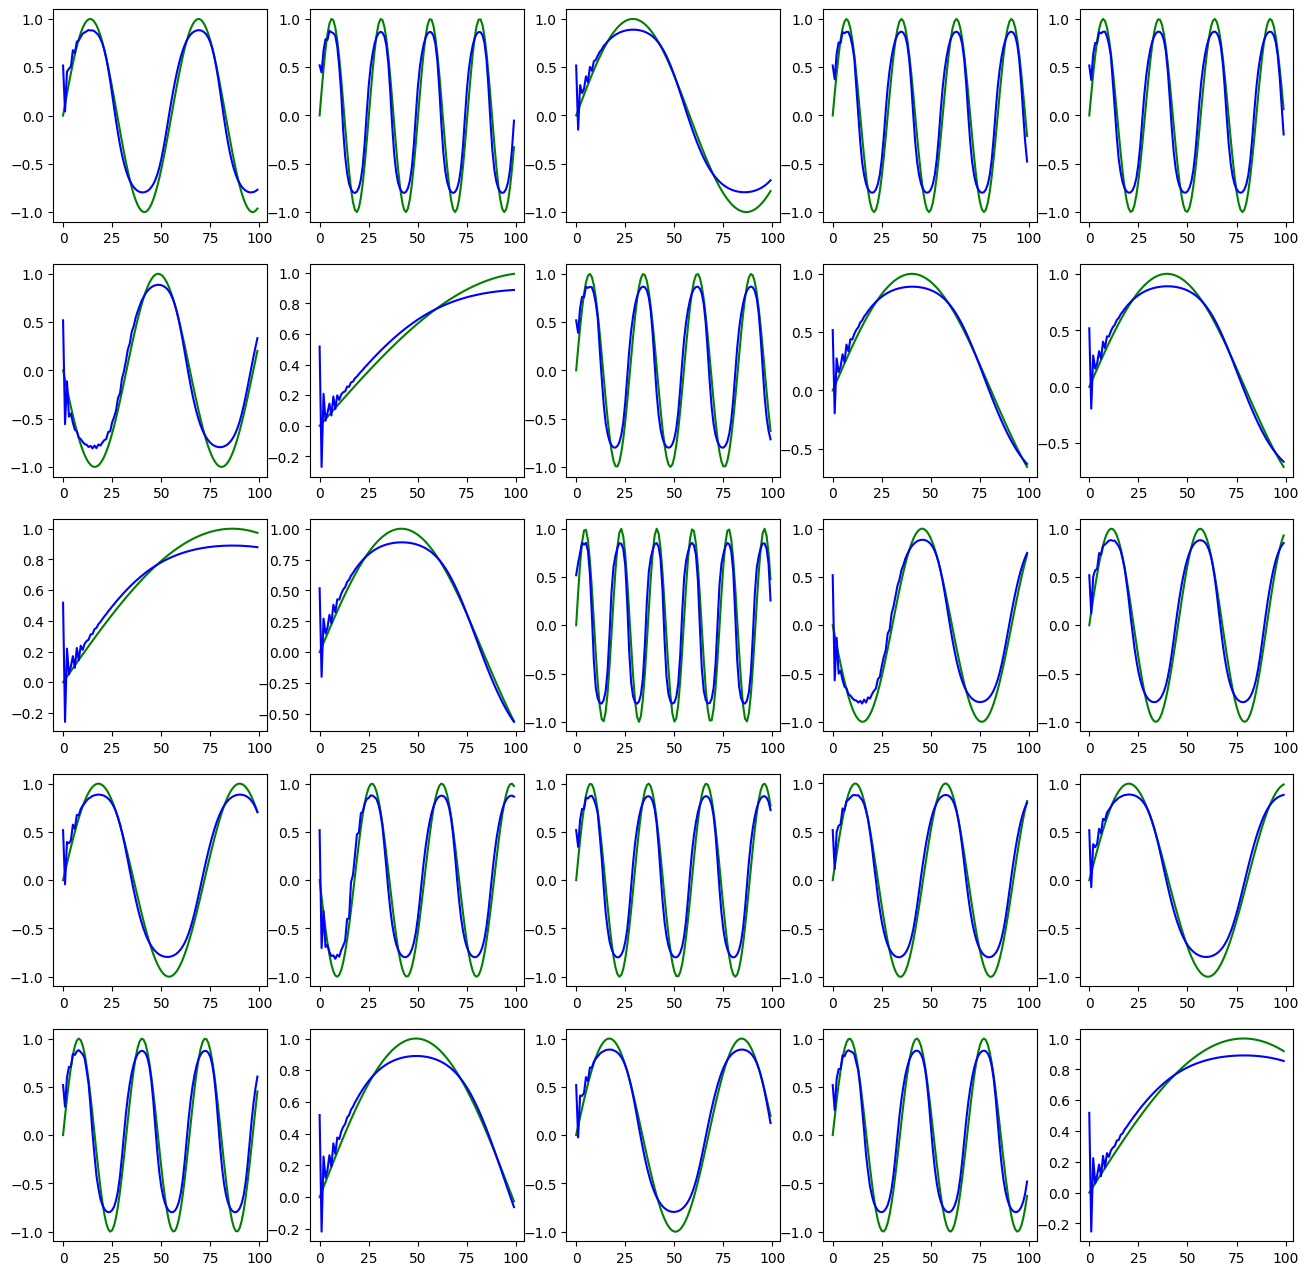

In [36]:
out = rnnmodel(traj, training=False)
x_samples = out["output"].numpy()

if sin:
    plt.figure(figsize=(16, 16))
    for i in range(1, 26):
        plt.subplot(5, 5, i)
        plt.plot(
            traj[i * 2, :, 0], color="green"
        )
        plt.plot(
            x_samples[i * 2, :, 0], color="blue"
        )
else:
    plt.figure(figsize=(16, 16))
    for i in range(1, 26):
        plt.subplot(5, 5, i)
        plt.plot(
            traj[i * 5, :, 0], traj[i * 5, :, 1], color="green"
        )
        plt.plot(
            x_samples[i * 5, :, 0], x_samples[i * 5, :, 1], color="blue"
        )
plt.show()

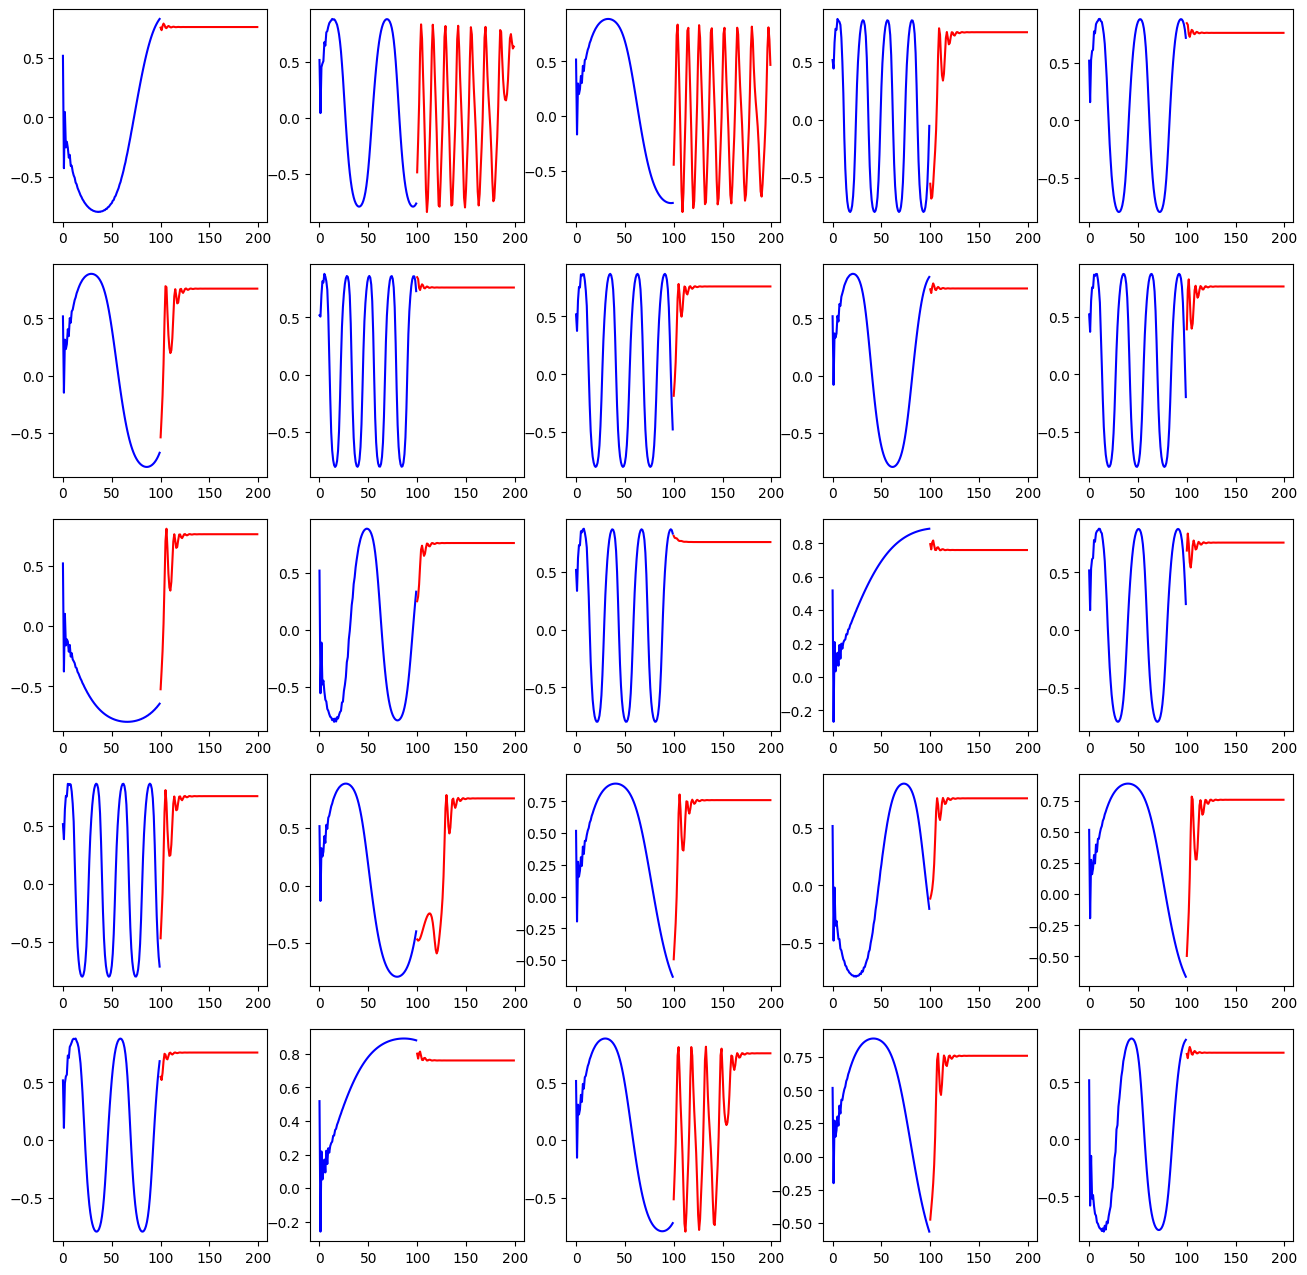

In [35]:
length = 100

out = rnnmodel.sample(traj, length=length)
x_samples = out["output"]
plt.figure(figsize=(16, 16))
base = np.arange(x_samples.shape[1])
for i in range(1, 26):
    plt.subplot(5, 5, i)
    plt.plot(
        base[:-length],
        x_samples[i, :-length, 0], color="blue"
    )
    plt.plot(
        base[-length:],
        x_samples[i, -length:, 0], color="red"
    )


In [28]:
rnnmodel._cell.get_initial_state(batch_size=10, dtype=tf.float32).shape

TensorShape([10, 15])

In [66]:
fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
dt = 1
x = np.zeros(3)
x_traj = np.empty(shape=(1000, 3))
for t in range(1000):
    x =  x + dataset[0, 0, t, -3:] * dt
    x_traj[t, :] = x

def animate(t):
    ax.plot(x_traj[:t, 0], x_traj[:t, 1], x_traj[:t, 2], color="black")

anim = FuncAnimation(fig, animate, 200)
anim.save("./animation.gif")

Using matplotlib backend: agg


MovieWriter ffmpeg unavailable; using Pillow instead.


In [77]:
dataset[0,0,2, :]

array([ 1.434186, -0.693527,  0.616938,  0.761832,  0.639253, -0.104726,
        0.865711,  0.179274, -0.130432, -0.0176  , -0.119279, -0.154231])

In [78]:
subjects.loc[2, "dws_1"].head(10)

/tmp/ipykernel_1129/1003011730.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  subjects.loc[2, "dws_1"].head(10)


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
idx,,,,,,,,,,,,
0,0.469622,-1.105773,-0.183192,0.202940,0.893811,-0.399888,-2.191344,1.836105,-0.723019,-0.232847,-0.688916,0.381181
1,0.515396,-1.156214,-0.173921,0.198531,0.915285,-0.350474,-2.363008,1.904480,-1.155867,-0.057052,-0.607515,0.339946
2,0.557269,-1.211266,-0.162511,0.186069,0.936062,-0.298593,-2.559274,1.177604,-1.169257,0.086240,0.302249,-0.259253
3,0.601952,-1.255618,-0.113787,0.175522,0.950741,-0.255488,-2.081134,-1.058971,-0.112989,0.024963,0.770023,-0.537816
4,0.674214,-1.284314,0.008391,0.176399,0.959244,-0.220738,-2.415788,-2.580961,0.902503,0.011223,0.471664,-0.478298
5,0.789042,-1.309334,0.175902,0.183434,0.966013,-0.182102,-2.323046,-2.045872,0.742231,-0.274712,-0.026926,-0.468334
6,0.888567,-1.323441,0.307796,0.190021,0.969563,-0.154365,-1.249245,-0.965344,0.526157,-0.381076,-0.086629,-0.465173
7,0.951838,-1.321871,0.371508,0.200641,0.969178,-0.142924,-0.232958,0.864321,0.564026,-0.398807,-0.165116,0.046977
8,0.997962,-1.309422,0.361271,0.217141,0.966036,-0.140051,0.908643,3.891206,0.264747,0.055991,-0.037187,0.717413


In [ ]:
model = models.DiscreteVariationalMixtureRNN(out_dim, clusters=clusters)

In [7]:
@tf.function
def step(model, inputs):
    with tf.GradientTape() as tape:
        out = model(traj, training=True)
        loss = -tf.reduce_mean(out["elbo"])
    grad = tape.gradient(loss, model.trainable_variables)
    return grad, loss

In [8]:
epochs = 1500
_ = model(traj)
optim = tf.keras.optimizers.RMSprop()
prog = tf.keras.utils.Progbar(epochs)
for i in range(epochs):
    grad, loss = step(model, traj)    
    optim.apply_gradients(zip(grad, model.trainable_variables))
    prog.update(i, values=[("elbo",loss)], finalize=False)
prog.update(i+1, values=[("elbo",loss)], finalize=True)
model.save(f"./assets/saved_models/dvrnn_{'sin' if sin else 'diff'}_{clusters}.keras")

2024-05-01 21:00:53.410548: I external/local_xla/xla/service/service.cc:168] XLA service 0xa94755d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-01 21:00:53.410601: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-05-01 21:00:53.843930: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-01 21:00:54.566795: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1714590054.872142  293122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 [==============================] - 1701s 1s/step - elbo: -83.8542


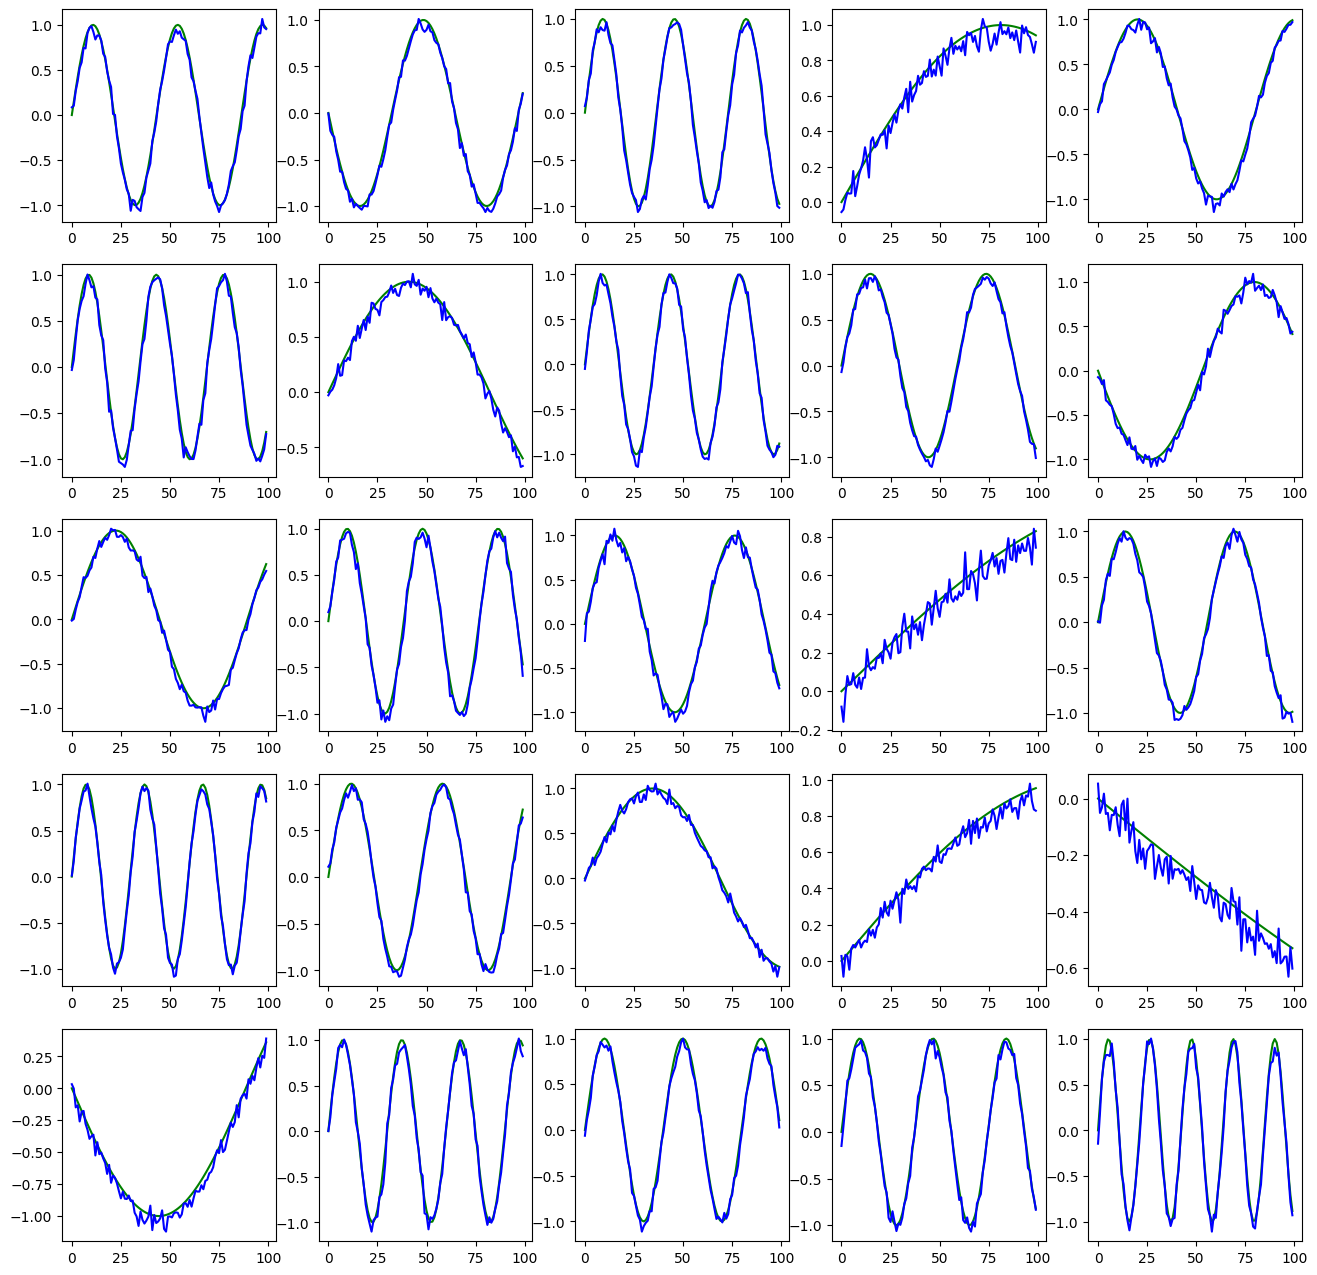

In [9]:
out = model(traj, training=False)
x_samples = out["x_samples"].numpy()
if sin:
    plt.figure(figsize=(16, 16))
    for i in range(1, 26):
        plt.subplot(5, 5, i)
        plt.plot(
            traj[i * 2, :, 0], color="green"
        )
        plt.plot(
            x_samples[i * 2, :, 0], color="blue"
        )
else:
    plt.figure(figsize=(16, 16))
    for i in range(1, 26):
        plt.subplot(5, 5, i)
        plt.plot(
            traj[i * 5, :, 0], traj[i * 5, :, 1], color="green"
        )
        plt.plot(
            x_samples[i * 5, :, 0], x_samples[i * 5, :, 1], color="blue"
        )

In [3]:
model = tf.keras.models.load_model("./assets/saved_models/dvrnn_sin_1.keras")

2024-05-01 21:59:48.281414: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 21:59:48.281686: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 21:59:48.281769: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 21:59:48.693902: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-01 21:59:48.694079: I external/local_xla/xla/stream_executor

In [11]:
reload(models)
model2 =  models.DiscreteVariationalMixtureRNN(out_dim, clusters=clusters)
_ = model2(traj)
model2.set_weights(model.get_weights())
#model = model2

In [16]:
unconditional = False
length = 100
samples = 200
from_prior = False

if unconditional:   
    out = model.sample(None, samples, length, from_prior=from_prior)
    x_samples = out["x_samples"]
    plt.figure(figsize=(16, 16))
    for i in range(1, 26):
        plt.subplot(5, 5, i)
        plt.plot(
            x_samples[i, :, 0], color="blue"
        )
else:
    trajin = traj[:, :50]
    out = model.sample(trajin, 30, length, from_prior=from_prior)
    x_samples = out["x_samples"]
    plt.figure(figsize=(16, 16))
    base = np.linspace(0, trajin.shape[1] + length, trajin.shape[1] + length)
    for i in range(1, 26):
        plt.subplot(5, 5, i)
        plt.plot(
            base[:-length],
            x_samples[i, :-length, 0], color="blue"
        )
        plt.plot(
            base[-length:],
            x_samples[i, -length:, 0], color="red"
        )

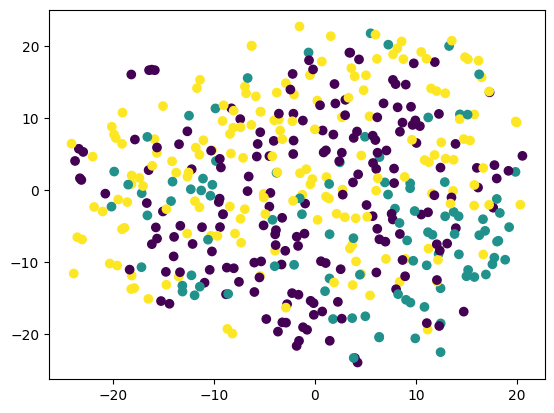

In [14]:
from sklearn.manifold import TSNE
zg = out["zg_sample"]
y = tf.argmax(out["y_sample"], -1)
emb = TSNE(n_components=2, perplexity=25)
emb = emb.fit_transform(zg.numpy())
plt.scatter(emb[:,0], emb[:, 1], c=y.numpy())

In [60]:
from src import data
reload(data)
path = "/mnt/a/Users/Claudio/Documents/Data/motion-sense/data"
save_path = "./assets/data"

motion = data.process_motion_sense(path, save_path)

folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_1.csv  subject: 1
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_10.csv  subject: 10
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_11.csv  subject: 11
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_12.csv  subject: 12
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_13.csv  subject: 13
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_14.csv  subject: 14
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_15.csv  subject: 15
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_16.csv  subject: 16
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_17.csv  subject: 17
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_18.csv  subject: 18
folder: A_DeviceMotion_data.zip  file: A_DeviceMotion_data/dws_1/sub_19.csv  subject: 19
folder: A_DeviceMotion_

In [61]:
motion

attitude.roll  attitude.pitch  attitude.yaw  gravity.x  \
subject movement idx                                                            
1       dws_1    0          1.528132       -0.733896      0.696372   0.741895   
                 1          1.527992       -0.716987      0.677762   0.753099   
                 2          1.527765       -0.706999      0.670951   0.759611   
                 3          1.516768       -0.704678      0.675735   0.760709   
                 4          1.493941       -0.703918      0.672994   0.760062   
...                              ...             ...           ...        ...   
9       wlk_8    4749       0.890518       -1.300928      0.089878   0.207249   
                 4750       0.929499       -1.319499      0.124063   0.199247   
                 4751       0.966103       -1.340284      0.159858   0.187951   
                 4752       1.005158       -1.362495      0.201540   0.174576   
                 4753       1.051479       -1.385380      0.249462   0.160035   

                       gravity.y  gravity.z  rotationRate.x  rotationRate.y  \
subject movement idx                                                          
1       dws_1    0      0.669768  -0.031672        0.316738        0.778180   
                 1      0.657116  -0.032255        0.842032        0.424446   
                 2      0.649555  -0.032707       -0.138143       -0.040741   
                 3      0.647788  -0.041140       -0.025005       -1.048717   
                 4      0.647210  -0.058530        0.114253       -0.912890   
...                          ...        ...             ...             ...   
9       wlk_8    4749   0.963806  -0.167690       -0.920226        0.406762   
                 4750   0.968591  -0.148750       -0.923594        0.231559   
                 4751   0.973550  -0.129883       -0.970054        0.003083   
                 4752   0.978384  -0.110827       -1.005371       -0.108297   
                 4753   0.982860  -0.091485       -0.944864        0.037529   

                       rotationRate.z  userAcceleration.x  userAcceleration.y  \
subject movement idx                                                            
1       dws_1    0           1.082764            0.294894           -0.184493   
                 1           0.643574            0.219405            0.035846   
                 2           0.343563            0.010714            0.134701   
                 3           0.035860           -0.008389            0.136788   
                 4           0.047341            0.199441            0.353996   
...                               ...                 ...                 ...   
9       wlk_8    4749       -0.383194            0.044079           -0.204574   
                 4750       -0.521862            0.066348           -0.222604   
                 4751       -0.621238           -0.005959           -0.054040   
                 4752       -0.708937           -0.007767           -0.003927   
                 4753       -0.732202           -0.010270            0.009374   

                       userAcceleration.z  
subject movement idx                       
1       dws_1    0               0.377542  
                 1               0.114866  
                 2              -0.167808  
                 3               0.094958  
                 4              -0.044299  
...                                   ...  
9       wlk_8    4749            0.204906  
                 4750            0.225136  
                 4751            0.240632  
                 4752            0.194735  
                 4753            0.136270  

[1412865 rows x 12 columns]